# Compare AEMO wind and sola observations with modelled

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import string
letters = list(string.ascii_lowercase)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
%cd /g/data/w42/dr6273/work/power_models/

/g/data/w42/dr6273/work/power_models


In [3]:
year = "2023"

## Load modelled data

In [4]:
regions = ["NSW", "QLD", "VIC", "SA", "TAS"]

In [5]:
path_power = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

#### Wind and solar power

For REZs
- Current/planned generation capacities. These sometimes underestimate observed power (i.e. from installed farms) because it spreads the capacity around the REZ, rather than being loaded on a single grid cell.

In [6]:
def preprocess_2023(ds):
    """
    Select one year only
    """
    return ds.sel(time="2023")

In [7]:
def preprocess_2020_2023(ds):
    """
    Select 2020-2023
    """
    return ds.sel(time=slice("2020-12", "2023-11"))

In [68]:
wind_rez_current = xr.open_mfdataset(
    path_power + "REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc",
    # preprocess=preprocess_2020_2023
    preprocess=preprocess_2023
)

In [46]:
solar_rez_current = xr.open_mfdataset(
    path_power + "REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc",
    # preprocess=preprocess_2020_2023
    preprocess=preprocess_2023
)

We also use the power from farms outside the REZs, and add this to the REZ power

In [72]:
wind_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc",
    # preprocess=preprocess_2020_2023
    preprocess=preprocess_2023
).astype("float32")

In [48]:
solar_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc",
    # preprocess=preprocess_2020_2023
    preprocess=preprocess_2023
).astype("float32")

Add these together

In [49]:
def get_REZ_for_state(ds, state):
    """
    Return list of REZ names for state
    
    ds: dataset with REZ dimension
    state: str, code or for state e.g. NSW, SA
    """
    return [i for i in ds.REZ.values if i[0] == state[0]]

In [50]:
def sum_REZ_power_for_states(ds, states=["NSW", "QLD", "VIC", "SA", "TAS"]):
    """
    Return array of ds summed for each REZ in each state
    
    ds: dataset with REZ dimension
    states: list, of strings of states
    """
    da_list = []
    for state in states:
        r = get_REZ_for_state(ds, state)
        da = ds.sel(REZ=r).sum("REZ").expand_dims({"region": [state]})
        da_list.append(da)
    return xr.concat(da_list, dim="region")

In [73]:
wind_rez_current = sum_REZ_power_for_states(wind_rez_current) + wind_outside_rez

In [52]:
solar_rez_current = sum_REZ_power_for_states(solar_rez_current) + solar_outside_rez

Hack add TAS for solar to keep it same format as site power.

In [53]:
solar_tas = xr.DataArray(
    np.zeros(len(solar_rez_current.time)),
    dims=["time"],
    coords={"time": solar_rez_current.time}
).expand_dims({"region": ["TAS"]})

In [54]:
solar_rez_current = xr.concat([solar_rez_current.power, solar_tas], "region").to_dataset(name="power")

In [74]:
wind_rez_current = wind_rez_current.compute()

In [56]:
solar_rez_current = solar_rez_current.compute()

## Load AEMO data

In [20]:
def open_aemo_obs(fuel_type, year, months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]):
    """
    Open monthly data and concatenate
    
    fuel_type: str, "wind" or "solar"
    year: str, year to open.
    months: list, each element a 2-character string indicating the month, e.g. '01', '02'.
    """
    df_list = []
    for month in months:
        df = pd.read_csv(
            "/scratch/w42/dr6273/processed_AEMO/aemo_hourly_" + fuel_type + "_" + year + "_" + month + ".csv",
            index_col=[0,1]
        )
        df_list.append(df)
        
    return pd.concat(df_list, axis=0)

In [21]:
def df_to_xarray(df):
    """
    Convert AEMO obs dataframe to xarray
    """
    # Convert to xarray DataSet
    ds = df.to_xarray()
    # Rename dimensions and variable name
    ds = ds.rename({"Region": "region", "SETTLEMENTDATE": "time", "INITIALMW": "power"})
    # Ensure coordinates are correct data type
    ds = ds.assign_coords({
        "region": ["NSW", "QLD", "SA", "TAS", "VIC"],
        "time": pd.to_datetime(ds["time"])
    })
    # Re-order region coordinate to match modelled data
    ds = ds.reindex({"region": ["NSW", "QLD", "VIC", "SA", "TAS"]})
    
    return ds

In [32]:
# wind_list = []
# solar_list = []

# months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

# for year in ["2020", "2021", "2022", "2023"]:
#     # We want December 2020 - November 2023
#     if year == "2020":
#         m = ["12"]
#     elif year == "2023":
#         m = months[:-1]
#     else:
#         m = months
        
#     w = open_aemo_obs("wind", year, m)
#     w_da = df_to_xarray(w).compute()
#     wind_list.append(w_da)
    
#     s = open_aemo_obs("solar", year, m)
#     # Pad with NaNs for TAS
#     s = s.reindex_like(w)
#     s_da = df_to_xarray(s).compute()
#     solar_list.append(s_da)

In [33]:
aemo_wind = open_aemo_obs("wind", year)

In [34]:
aemo_solar = open_aemo_obs("solar", year)
# Pad with NaNs for TAS
aemo_solar = aemo_solar.reindex_like(aemo_wind)

In [35]:
aemo_wind = df_to_xarray(aemo_wind).compute()

In [36]:
aemo_solar = df_to_xarray(aemo_solar).compute()

### Compare

In [27]:
def scatter(ax, region, fuel_type, obs, mod, energy_units, plot_daily=True, plot_monthly=True, add_legend=False, alpha=0.5):
    """
    Scatter plot obs against model
    
    ax: axes to plot on
    region: str, name of region
    fuel_type: str, name of fuel
    obs: array, observations
    mod: array: predictions
    energy_units: str, units to display
    plot_daily: bool, whether to plot daily values
    plot_monthly: bool, whether to plot monthly means
    add_legend: bool, whether to add legend
    """
    seas_months = [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
    colors = ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]
    labels = ["DJF", "MAM", "JJA", "SON"]
    markers = ["o", "d", "v", "s"]

    for months, color, label, marker in zip(
        seas_months, colors, labels, markers
    ):
        o = obs.isel(time=obs.time.dt.month.isin(months))
        m = mod.isel(time=mod.time.dt.month.isin(months))

        if plot_daily:
            ax.scatter(o, m, color=color, s=20, marker="o", alpha=alpha, label=label)
        
        if plot_monthly:
            if plot_daily:
                month_marker = "s"
            else:
                month_marker = "o"
                
            for month in months:
                if plot_daily:
                    m_obs = o.isel(time=o.time.dt.month == month).mean()
                    m_mod = m.isel(time=m.time.dt.month == month).mean()
                else:
                    m_obs = o.isel(time=o.time.dt.month == month).mean()
                    m_mod = m.isel(time=m.time.dt.month == month).mean()
                ax.scatter(m_obs, m_mod, color=color, s=50, marker=month_marker, edgecolor="k", zorder=3)

    if plot_daily:
        line_coords = np.arange(obs.min().min(), obs.max().max())
        ax.plot(line_coords, line_coords, color="k", zorder=4)

    ax.set_xlabel("Observed [" + energy_units + "]")
    ax.set_ylabel("Modelled [" + energy_units + "]")
    ax.set_title(region + ", " + fuel_type, loc="left", fontsize=10)
    
    if add_legend:
        cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in colors]
        
        if plot_monthly:
            if plot_daily:
                col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
                col2 = [Line2D([0], [0], marker=month_marker, linestyle="None", color="tab:gray")]
                blank = [Line2D([0], [0], marker=month_marker, linestyle="None", color="w")]
                cols = cols + blank + col1 + col2
                labels = labels + ["", "Daily", "Monthly"]

        ax.legend(cols, labels, frameon=False)

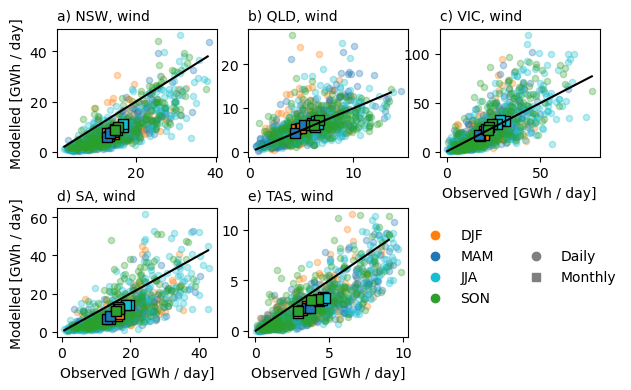

In [236]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    scatter(
        ax.flatten()[i],
        letters[i] + ") " + region,
        "wind",
        aemo_wind_no_outliers.sel(region=region)["power"].resample(time="1D").sum() / 1000,
        wind_rez_current.sel(region=region)["power"].sel(time=aemo_wind_no_outliers.time.values).resample(time="1D").sum() / 1000,
        "GWh / day",
        alpha=0.3
    )
    
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    if i < 2:
        ax.flatten()[i].set_xlabel("")
        
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_wind_raw.pdf", format="pdf", bbox_inches="tight")

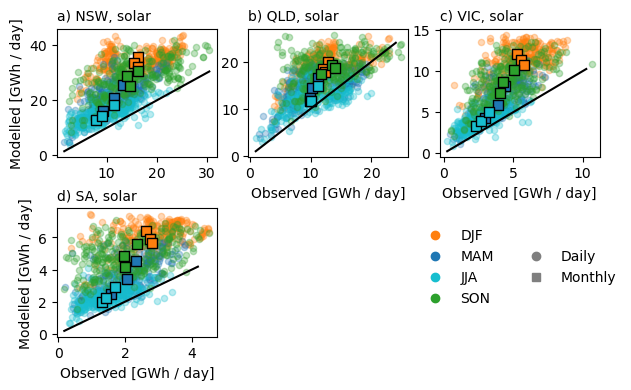

In [237]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    if i < 4:
        scatter(
            ax.flatten()[i],
            letters[i] + ") " + region,
            "solar",
            aemo_solar_no_outliers.sel(region=region)["power"].resample(time="1D").sum() / 1000,
            solar_rez_current.sel(region=region)["power"].sel(time=aemo_solar_no_outliers.time.values).resample(time="1D").sum() / 1000,
            "GWh / day",
            alpha=0.3
        )

        if i in [1, 2, 4, 5]:
            ax.flatten()[i].set_ylabel("")
        if i < 1:
            ax.flatten()[i].set_xlabel("")
        
ax[-1,-2].axis("off")
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_solar_raw.pdf", format="pdf", bbox_inches="tight")

### Find scaling factors for bias correction

In [238]:
# openNEM_solar_2023 = np.array([6368, 5845, 1546, 825, 0]) * 1000
# openNEM_wind_2023 = np.array([5754, 2605, 11076, 6304, 1890]) * 1000

In [75]:
wind_rez_scaled = wind_rez_current.assign_coords(
    # scale_factor_2023=("region", wind_rez_current.power.sum("time").values / openNEM_wind_2023)
    scale_factor_2023=(
        "region",
        aemo_wind.power.sel(time="2023").sum("time").values / wind_rez_current.power.sel(time="2023").sum("time").values
    )
)

In [76]:
solar_rez_scaled = solar_rez_current.assign_coords(
    # scale_factor_2023=("region", solar_rez_current.power.sum("time").values / openNEM_solar_2023)
    scale_factor_2023=(
        "region",
        aemo_solar.power.sel(time="2023").sum("time").values / solar_rez_current.power.sel(time="2023").sum("time").values
    )
)

/jobfs/146172520.gadi-pbs/ipykernel_2621942/730290751.py:5: RuntimeWarning: invalid value encountered in divide
  aemo_solar.power.sel(time="2023").sum("time").values / solar_rez_current.power.sel(time="2023").sum("time").values


In [77]:
wind_rez_scaled.scale_factor_2023

<xarray.DataArray 'scale_factor_2023' (region: 5)> Size: 40B
array([2.02321105, 1.25639303, 1.13581679, 1.72883961, 1.47794378])
Coordinates:
  * region             (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    scale_factor_2023  (region) float64 40B 2.023 1.256 1.136 1.729 1.478

In [78]:
solar_rez_scaled.scale_factor_2023

<xarray.DataArray 'scale_factor_2023' (region: 5)> Size: 40B
array([0.6638736 , 0.95382913, 0.54762614, 0.55381373,        nan])
Coordinates:
  * region             (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    scale_factor_2023  (region) float64 40B 0.6639 0.9538 0.5476 0.5538 nan

In [255]:
wind_rez_scaled = wind_rez_scaled.power * wind_rez_scaled.scale_factor_2023
solar_rez_scaled = solar_rez_scaled.power * solar_rez_scaled.scale_factor_2023

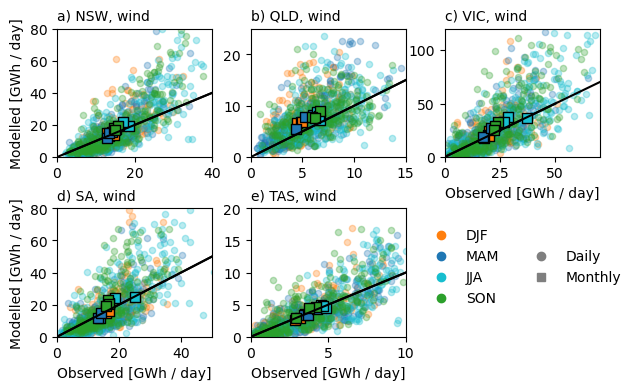

In [256]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    scatter(
        ax.flatten()[i],
        letters[i] + ") " + region,
        "wind",
        aemo_wind.sel(region=region)["power"].resample(time="1D").sum() / 1000,
        wind_rez_scaled.sel(region=region).resample(time="1D").sum() / 1000,
        "GWh / day",
        alpha=0.3,
        plot_daily=True,
        plot_monthly=True
    )
    
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    if i < 2:
        ax.flatten()[i].set_xlabel("")
        
for a in ax.flatten()[:-1]:
    a.plot(range(51), range(51), c="k")
             
ax[0,0].set_xlim(0, 40)
ax[0,0].set_ylim(0, 80)

ax[0,1].set_xlim(0, 15)
ax[0,1].set_ylim(0, 25)

ax[0,2].set_xlim(0, 70)
ax[0,2].set_ylim(0, 120)

ax[1,0].set_xlim(0, 50)
ax[1,0].set_ylim(0, 80)

ax[1,1].set_xlim(0, 10)
ax[1,1].set_ylim(0, 20)

ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
labels = ["DJF", "MAM", "JJA", "SON"]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_wind_scaled.pdf", format="pdf", bbox_inches="tight")

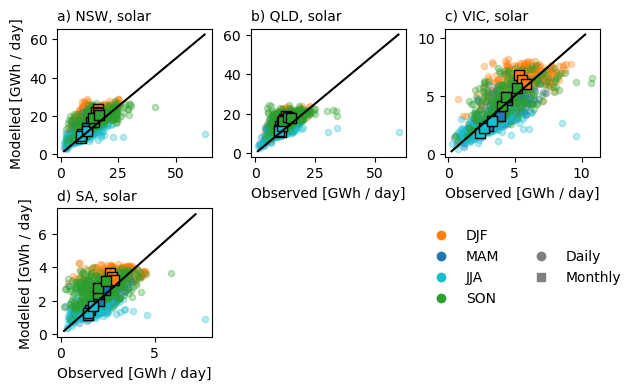

In [257]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    if i < 4:
        scatter(
            ax.flatten()[i],
            letters[i] + ") " + region,
            "solar",
            aemo_solar.sel(region=region)["power"].resample(time="1D").sum() / 1000,
            solar_rez_scaled.sel(region=region).resample(time="1D").sum() / 1000,
            "GWh / day",
            alpha=0.3
        )

        if i in [1, 2, 4, 5]:
            ax.flatten()[i].set_ylabel("")
        if i < 1:
            ax.flatten()[i].set_xlabel("")
        
ax[-1,-2].axis("off")
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_solar_scaled.pdf", format="pdf", bbox_inches="tight")

### Also try additive bias

In [90]:
nHours = len(wind_rez_current.power.sel(time="2023").time.values)
nHours

8760

In [91]:
wind_rez_add = wind_rez_current.assign_coords(
    add_factor_2023=(
        "region",
        (aemo_wind.power.sel(time="2023").sum("time").values - wind_rez_current.power.sel(time="2023").sum("time").values) / nHours
    )
)

In [92]:
solar_rez_add = solar_rez_current.assign_coords(
    add_factor_2023=(
        "region",
        (aemo_solar.power.sel(time="2023").sum("time").values - solar_rez_current.power.sel(time="2023").sum("time").values) / nHours
    )
)

In [93]:
wind_rez_add.add_factor_2023

<xarray.DataArray 'add_factor_2023' (region: 5)> Size: 40B
array([309.8022297 ,  60.72493591, 131.90805994, 303.58661418,
        52.86070789])
Coordinates:
  * region           (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    add_factor_2023  (region) float64 40B 309.8 60.72 131.9 303.6 52.86

In [94]:
solar_rez_add.add_factor_2023

<xarray.DataArray 'add_factor_2023' (region: 5)> Size: 40B
array([-360.4486987 ,  -31.81565915, -145.88216082,  -78.82479538,
          0.        ])
Coordinates:
  * region           (region) object 40B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    add_factor_2023  (region) float64 40B -360.4 -31.82 -145.9 -78.82 0.0

In [95]:
wind_rez_add = wind_rez_add.power + wind_rez_add.add_factor_2023
solar_rez_add = solar_rez_add.power + solar_rez_add.add_factor_2023

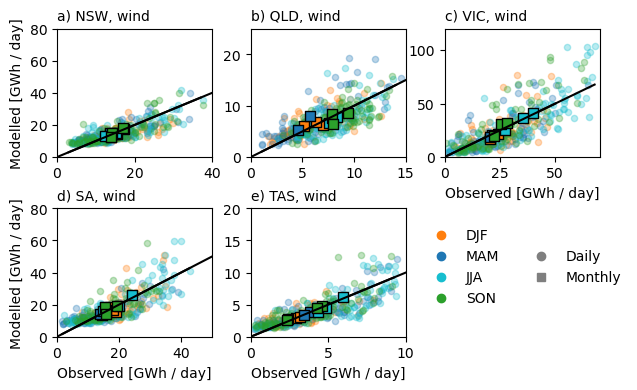

In [97]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    scatter(
        ax.flatten()[i],
        letters[i] + ") " + region,
        "wind",
        aemo_wind.sel(region=region)["power"].resample(time="1D").sum() / 1000,
        wind_rez_add.sel(region=region).resample(time="1D").sum() / 1000,
        "GWh / day",
        alpha=0.3,
        plot_daily=True,
        plot_monthly=True
    )
    
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_ylabel("")
    if i < 2:
        ax.flatten()[i].set_xlabel("")
        
for a in ax.flatten()[:-1]:
    a.plot(range(51), range(51), c="k")
             
ax[0,0].set_xlim(0, 40)
ax[0,0].set_ylim(0, 80)

ax[0,1].set_xlim(0, 15)
ax[0,1].set_ylim(0, 25)

ax[0,2].set_xlim(0, 70)
ax[0,2].set_ylim(0, 120)

ax[1,0].set_xlim(0, 50)
ax[1,0].set_ylim(0, 80)

ax[1,1].set_xlim(0, 10)
ax[1,1].set_ylim(0, 20)

ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
labels = ["DJF", "MAM", "JJA", "SON"]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = ["DJF", "MAM", "JJA", "SON"]
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_wind_scaled.pdf", format="pdf", bbox_inches="tight")

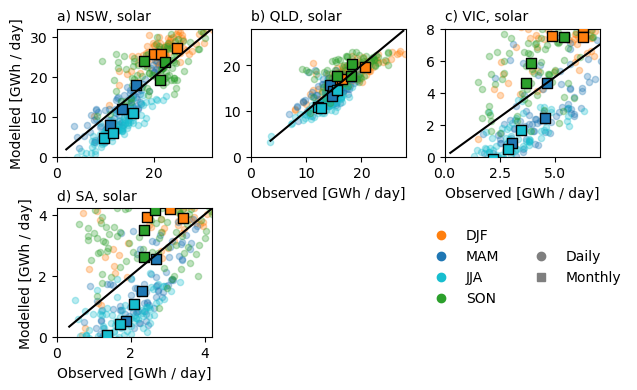

In [99]:
fig, ax = plt.subplots(2, 3, figsize=(7,4))

for i, region in enumerate(wind_rez_current.region.values):
    if i < 4:
        scatter(
            ax.flatten()[i],
            letters[i] + ") " + region,
            "solar",
            aemo_solar.sel(region=region)["power"].resample(time="1D").sum() / 1000,
            solar_rez_add.sel(region=region).resample(time="1D").sum() / 1000,
            "GWh / day",
            alpha=0.3
        )

        if i in [1, 2, 4, 5]:
            ax.flatten()[i].set_ylabel("")
        if i < 1:
            ax.flatten()[i].set_xlabel("")
        
ax[0,0].set_xlim(0, 32)
ax[0,0].set_ylim(0, 32)

ax[0,1].set_xlim(0, 28)
ax[0,1].set_ylim(0, 28)

ax[0,2].set_xlim(0, 7)
ax[0,2].set_ylim(0, 8)

ax[1,0].set_xlim(0, 4.2)
ax[1,0].set_ylim(0, 4.2)      

ax[-1,-2].axis("off")
ax[-1,-1].axis("off")
        
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# Manual legend
cols = [Line2D([0], [0], marker='o', linestyle="None", color=c) for c in ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]]
col1 = [Line2D([0], [0], marker='o', linestyle="None", color="tab:gray")]
col2 = [Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")]
blank = [Line2D([0], [0], marker='s', linestyle="None", color="w")]
cols = cols + blank + col1 + col2
labels = labels + ["", "Daily", "Monthly"]

ax[-1,-1].legend(cols, labels, ncols=2, frameon=False, loc=(-0.15, 0.2))

# plt.savefig("figures/model_solar_scaled.pdf", format="pdf", bbox_inches="tight")

Additive bias correction doesn't work for solar. It works better than multiplicative bias correction for high wind generation, but worse for low wind generation. For monthly means of wind, both methods seem OK.